In [33]:
import cv2
import numpy as np
from numpy.core.defchararray import join, mod
import pandas as pd 
import matplotlib.pyplot as plt 
import albumentations as A
import requests
from io import BytesIO
from PIL import Image
import random 
import torch
from tqdm.notebook import tqdm
import torch.nn as nn 
from torch._C import device
import torch.optim as optim
import torch.autograd.grad_mode as grad_mode
from torch.autograd import Function as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import  AnchorGenerator
import os
from torchvision import transforms as torchtrans


C:\Users\eduar\AppData\Local\Temp\ipykernel_27496\1853367424.py:3: DeprecationWarning: numpy.core.defchararray is deprecated and has been renamed to numpy._core.defchararray. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.defchararray.join.
  from numpy.core.defchararray import join, mod
C:\Users\eduar\AppData\Local\Temp\ipykernel_27496\1853367424.py:3: DeprecationWarning: numpy.core.defchararray is deprecated and has been renamed to numpy._core.defchararray. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-wo

In [34]:
device_used = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device_used)

cuda


In [35]:
def imgshow(number, title=None, size=5):
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    root = os.path.join(project_root, "artifacts", "raw")

    img_path = os.path.join(root, "images", f"{number}.jpeg")
    label_path = os.path.join(root, "labels", f"{number}.txt")

    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return
    if not os.path.exists(label_path):
        print(f"Lable not found: {label_path}")
        return
    
    image = cv2.imread(img_path)

    with open(label_path, "r") as f:
        lines = f.readlines()

    num_boxes = int(lines[0].strip())
    for i in range(num_boxes):
        indices = [int(x) for x in lines[i+1].strip().split()]
        start_point = (indices[0], indices[1])
        end_point = (indices[2], indices[3])
        cv2.rectangle(image, start_point, end_point, (0,0, 255), 2) 

    aspect_ratio = image.shape[0]/image.shape[1]
    plt.figure(figsize=(size+aspect_ratio, size ))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if title:
        plt.title(f"{title} - {num_boxes} box(es)")
        plt.axis('off')
        plt.show()        

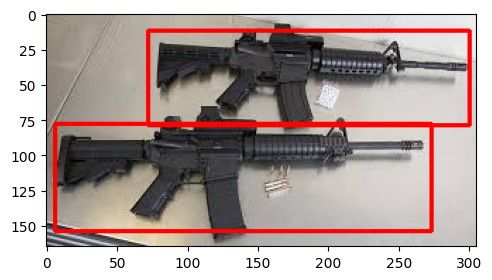

In [36]:
imgshow(number=119)

In [37]:
class Gun_Data(Dataset):

    def __init__(self, root):
        self.image_path = root+"images/"
        self.labels_path = root+"labels/"

        self.img_name = [img for img in sorted(os.listdir(self.image_path))] 
        self.label_name = [label for label in sorted(os.listdir(self.labels_path))]


    def __getitem__(self, idx):
        image_path = os.path.join(self.image_path, str(self.img_name[idx]))
        image = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        img_res = img_rgb/255
        img_res = torch.as_tensor(img_res).permute(2,0,1)

        label_name = self.img_name[idx] [:-4] + "txt"
        label_path = os.path.join(self.labels_path, str(label_name))

        with open(label_path, "r") as label_file:
            l_count = int(label_file.readline())
            box=[]
            for i in range(l_count):
                box.append(list(map(int,label_file.readline().split())))

        target={}
        area=[]
        labels=[]

        for i in range(len(box)):
            a = ((box[i][2]-box[i][0]) *  (box[i][3]-box[i][1]))
            area.append(a)

        for i in range(len(box)):
            labels.append(1)

        target["boxes"] = torch.as_tensor(box, dtype=torch.float32)
        target["area"] = torch.as_tensor(area)
        target["image_id"] = torch.as_tensor([idx])
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)

        img_res = img_res.to(device_used)

        for key in target:
            if isinstance(target[key], torch.Tensor):
                target[key] = target[key].to(device_used)

        return img_res, target

    def __len__(self):
        return len(self.img_name)   

In [38]:
class Model:
    def __init__(self, num):
        self.num = num
        self.model = self.create_model()

    def create_model(self):
        model = fasterrcnn_resnet50_fpn(pretrained=True)

        in_features = model.roi_heads.box_predictor.cls_score.in_features

        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num)

        return model
    
    def compiler(self, optimizer):
        self.optmizer = optimizer

    def train(self, train_data, val_data):
        for epoch in tqdm(range((num_epoch))):
            self.model = self.model.to(device_used)

            train_loss=0
            self.model.train()

            for img,target in train_data:
                loss_dic =self.model(img, target)
                loss =sum(loss for loss in loss_dic.values())

                self.optmizer.zero_grad()
                loss.backward()

                self.optmizer.step()
                train_loss += loss

            print(f"Epoch: {epoch+1} | Train Loss : {train_loss}")            

In [39]:
rcnn = Model(2)

model = rcnn.model

optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epoch = 30

rcnn.compiler(optimizer)

def collate_fn(batch):
    return tuple(zip(*batch))


dataset = Gun_Data(r'D:\MLOPS\MLOPS_PROJECT_FOUR\artifacts\raw/')

train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False, num_workers=0, collate_fn=collate_fn)


d:\MLOPS\MLOPS_PROJECT_FOUR\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\MLOPS\MLOPS_PROJECT_FOUR\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
rcnn.train(train_loader, val_loader)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | Train Loss : 22.275114059448242
Epoch: 2 | Train Loss : 17.54205894470215
Epoch: 3 | Train Loss : 15.190483093261719
Epoch: 4 | Train Loss : 13.060240745544434
Epoch: 5 | Train Loss : 12.021175384521484
Epoch: 6 | Train Loss : 9.888721466064453
Epoch: 7 | Train Loss : 8.555176734924316
Epoch: 8 | Train Loss : 7.618084907531738
Epoch: 9 | Train Loss : 7.097015857696533
Epoch: 10 | Train Loss : 7.643043041229248
Epoch: 11 | Train Loss : 6.936210632324219
Epoch: 12 | Train Loss : 6.374000549316406
Epoch: 13 | Train Loss : 5.652802467346191
Epoch: 14 | Train Loss : 5.113260746002197
Epoch: 15 | Train Loss : 5.22191047668457
Epoch: 16 | Train Loss : 4.549286365509033
Epoch: 17 | Train Loss : 4.631951808929443
Epoch: 18 | Train Loss : 4.700915336608887
Epoch: 19 | Train Loss : 4.564816951751709
Epoch: 20 | Train Loss : 4.159852981567383
Epoch: 21 | Train Loss : 3.958263635635376
Epoch: 22 | Train Loss : 3.821309804916382
Epoch: 23 | Train Loss : 3.2496023178100586
Epoch: 24 | Trai

In [41]:
def test(data, number=random.randint(1,334)):
    img, target = data[number]
    model.eval()

    predictions = model([img])

    predictions = [{k:v.to(device_used) for k,v in t.items()} for t in predictions]

    return predictions, target, img 

In [42]:
def apply_nms(orig_predictions, iou_treshold=None):

    keep = torchvision.ops.nms(orig_predictions["boxes"], orig_predictions["scores"], iou_treshold)

    final_predictions = orig_predictions
    final_predictions["boxes"] = final_predictions["boxes"][keep]
    final_predictions["scores"] = final_predictions["scores"][keep]
    final_predictions["labels"] = final_predictions["labels"][keep]

    return final_predictions

In [43]:
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')


In [44]:
def plot_img_bbox(img,target, size=5):
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    for box in target["boxes"]:
        x, y, width, height = box.tolist()
        cv2.rectangle(img_cv, (int(x), int(y)), (int(x+width), int(y+height)), (0, 0, 255), 2)

    aspect_ratio = img_cv.shape[0]/ img_cv.shape[1] 

    plt.figure(figsize=(size*aspect_ratio , size))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.show()

In [45]:
predictions, target, img = test(dataset, number=10)

In [46]:
nms_prediction = apply_nms(predictions[0], iou_treshold=0.7)

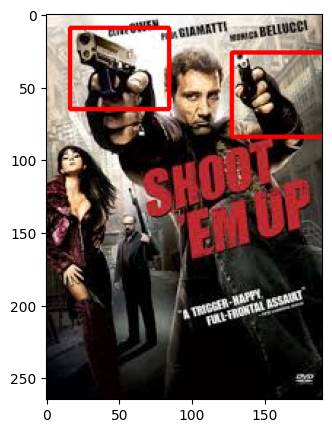

In [47]:
plot_img_bbox(torch_to_pil(img), target)

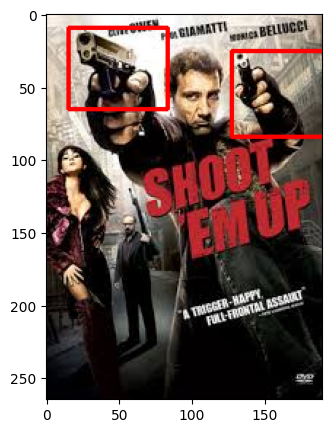

In [48]:
plot_img_bbox(torch_to_pil(img), nms_prediction)